---
title: "Let's make GARCH more flexible with Normalizing Flows"
author: "Sarem"
date: "2022-06-27"
categories: [Time Series]
format:
  html:
    toc: true
    toc-location: left
    toc-depth: 2
    toc-title: Contents
description-meta: "Who says that the GARCH conditional distribution needs to be Gaussian"
---

## Introduction

For financial time-series data, GARCH ([Generalized AutoRegressive Conditional Heteroscedasticity](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity?ref=sarem-seitz.com#GARCH(p,_q)_model_specification:~:text=the%20null%20hypothesis.-,GARCH,-%5Bedit%5D)) models play an important role. While forecasting mean returns is usually futile, stock volatility appears to be predictable, at least to some extent. However, standard GARCH relies on the potentially limiting assumption of conditional Gaussian data.

[Just like last time](https://sarem-seitz.com/blog/arma-forecasting-for-non-gaussian-time-series-data-using-copulas/?ref=sarem-seitz.com), we could use a Copula approach to remove such Gaussianity assumptions. Given that stock time-series typically have a lot of observations, a more flexible approach might be superior. In fact, it would be great if our model could simply infer the conditional distribution from the data provided.

A popular approach in Machine Learning to such problems are [Normalizing Flows](https://arxiv.org/abs/1908.09257?ref=sarem-seitz.com). In summary, Normalizing Flows allow to transform a known base distribution to a complex one in a differentiable manner. Let us briefly look at the technicalities:

## A short intro to Normalizing Flows
When choosing a probability model, we typically see a trade-off between **flexibility and tractability**. While the Gaussian distribution is nice to work with, real world data is obviously much more complex on most occasions.

On the other extreme, we see modern generative models like [GANs](https://en.wikipedia.org/wiki/Generative_adversarial_network?ref=sarem-seitz.com) that can produce complex data at the cost of an intractable distribution. This requires the use of sampling estimators for parameter estimation which can be quite inefficient.

Somewhere in the middle, we have Normalizing Flows. One the one hand, the expressiveness of Normalizing Flows might still be too limited for advanced image generation. Nonetheless, they are likely sufficient as a replacement for a mere Normal distribution.

### The core principle behind Normalizing Flows
At the heart of Normalizing Flows, we have the change-of-variables formula. The latter tells us how the density of a random variable changes under monotone transformations. As we are only interested in transformations of univariate variables, we will focus on the respective variant:

> Let $p_X(\cdot)$ denote the probability density of a (univariate) random variable $X$. Let $g: \mathbb{R} \mapsto \mathbb{R}$ denote a strictly monotonic transformation. For the probability density $p_Y(\cdot)$ of $\mathrm{Y}=\mathrm{g}(\mathrm{X})$ we have :
$$
p_Y(y)=p_X\left(g^{-1}(y)\right)\left|\frac{d}{d y} g^{-1}(y)\right|
$$

In summary, this formula allows us to generate new random variables from known ones. At the same time, we can calculate the probability density of the derived random variable in closed form. Of course, the limiting factor here is the restriction of $g$ to strictly monotonic functions. As we will see, however, this still leaves plenty of room for reasonably flexible distributions.

In Normalizing Flows, we now make the following crucial observation:

> *Chaining strictly monotonic functions results in another, more complex strictly monotonic function.*

Put into an equation, this looks as follows:

>Let $g_1, \ldots, g_M$ be strictly monotonic. It then follows that
$$
\tilde{g}=g_M \circ \cdots \circ g_1
$$
is also strictly monotonic.

If we define the outcome variable after the m-th transformation as
$$
X_m=g_m \circ \cdots \circ g_1\left(X_0\right)
$$
we can derive the (log-) density for the resulting variable after the M-th transformation by applying the chain rule:
$$
\begin{gathered}
p_{X_M}\left(x_m\right)=p_{X_0}\left(\tilde{g}^{-1}\left(x_M\right)\right)\left|\frac{d}{d x_M} \tilde{g}^{-1}\left(x_M\right)\right| \\
=p_{X_0}\left(x_0\right)\left|\prod_{m=1}^M\left(g_m^{-1}\right)^{\prime}\left(x_m\right)\right| \\
=p_{X_0}\left(x_0\right) \prod_{m=1}^M\left|\left(g_m\right)^{\prime}\left(x_{m-1}\right)\right|^{-1} \\
\Rightarrow \\
\log p_{X_m}\left(x_m\right)=\log p_{X_0}\left(x_0\right)+\sum^M \log \left|\left(g_m\right)^{\prime}\left(x_{m-1}\right)\right|^{-1}
\end{gathered}
$$
which can then be used for maximum likelihood optimization. Notice that we used the [inverse function theorem](https://en.wikipedia.org/wiki/Inverse_function_theorem?ref=sarem-seitz.com) to exchange the transformation with its inverse.

Now, all boils down to a reasonable choice of the component-wise transformations.

### Planar Normalizing Flows
A simple type of Normalizing Flows are **Planar Normalizing Flows** defined as
$$
g_\theta(x)=x+a \cdot h(w x+b) \quad \theta=(a, w, b)^T
$$
where $h$ denotes a smooth, non-linear function. The corresponding derivative is
$$
g_\theta^{\prime}=1+a w \cdot h^{\prime}(w x+b)
$$
This looks quite similar to residual layers in [Residual Neural Networks](https://en.wikipedia.org/wiki/Residual_neural_network?ref=sarem-seitz.comhttps://en.wikipedia.org/wiki/Residual_neural_network?ref=sarem-seitz.com). Thanks to the residual x in the left summand, the requirements on h are more loose than the initial monotonicity assumption. A common choice for the latter is simply the `tanh` function.

Intuitively, the Planar Flow takes the original variable and adds a non-linear transformation. We can expect the result to resemble the input with some variation, depending on the magnitude of $a$ and $w$.

To run our experiments, we can use the [Bijectors.jl](https://github.com/TuringLang/Bijectors.jl?ref=sarem-seitz.com) package which conveniently contains a Planar Flow layer:

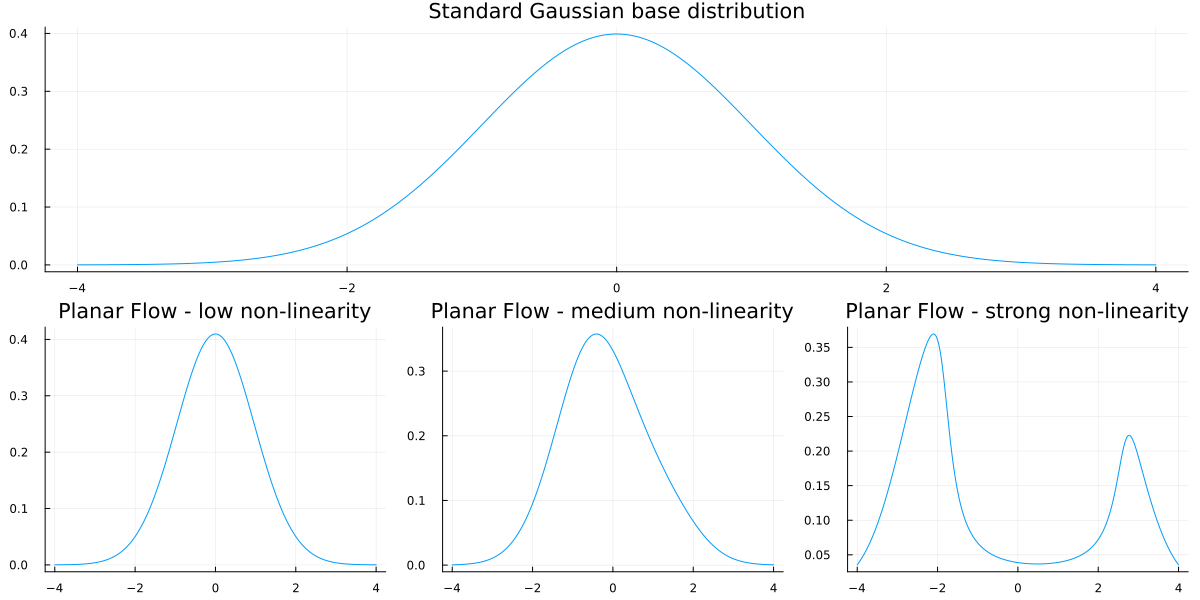

In [2]:
using Distributions, Plots, StatsPlots, Bijectors, Random

Random.seed!(321)
baseDist = MvNormal(zeros(1),ones(1)) #standard Gaussian as vector random variable Bijectors.PlanarLayer expects vector valued r.v.s
planarLayer1 = PlanarLayer([0.5],[1.],[0.])
planarLayer2 = PlanarLayer([1.],[1.],[-1.])
planarLayer3 = PlanarLayer([5.],[2.],[-2.])

flowDist1 = transformed(baseDist, planarLayer1)
flowDist2 = transformed(baseDist, planarLayer2)
flowDist3 = transformed(baseDist, planarLayer3)

line = Matrix(transpose(collect(-4:0.01:4)[:,:]))


base_plot = plot(line[:],pdf(baseDist,line)[:],legend=:none,title = "Standard Gaussian base distribution", fmt=:png)
flow1_plot = plot(line[:],pdf(flowDist1,line)[:],legend=:none,title = "Planar Flow - low non-linearity", fmt=:png)
flow2_plot = plot(line[:],pdf(flowDist2,line)[:],legend=:none,title = "Planar Flow - medium non-linearity", fmt=:png)
flow3_plot = plot(line[:],pdf(flowDist3,line)[:],legend=:none,title = "Planar Flow - strong non-linearity", fmt=:png)

flow_plot = plot(flow1_plot, flow2_plot, flow3_plot,layout = (1,3))

plot(base_plot, flow_plot, layout = (2,1), size = (1200,600))

## Non-Gaussian GARCH via Planar Normalizing Flows
By combining GARCH with Normalizing Flows, we aim for two goals:

1. **Remove the assumption of conditional Gaussian** realizations while, at the same time
2. **Preserve the autoregressive volatility property** that is inherent to GARCH models

For this article, we will focus on a simple GARCH(1,1) model. In an applied setting, we would want to try out different GARCH models and select the best one(s).

Recall that, for GARCH(1,1) with zero mean, we have:
$$
\begin{gathered}
y_t=\epsilon_t \sigma_t \quad \epsilon_t \sim \mathcal{N}(0,1) \\
\sigma_t=\sqrt{\gamma+\alpha \sigma_{t-1}^2+\beta \epsilon_{t-1}^2} \\
\gamma, \alpha, \beta \geq 0, \quad \alpha+\beta<1
\end{gathered}
$$
With the above restrictions, the GARCH model can be shown to be stationary. While the conditional distributions are all Gaussian, the unconditional ones are not.

Now, in order to combine this with Normalizing Flows, we apply the following transformation:
$$
\tilde{y}_t=g\left(y_t\right)
$$
where $g: \mathbb{R} \mapsto \mathbb{R}$ is a Normalizing Flow

This choice can be justified by the fact that a 1D Normalizing Flow is a monotone transformation and by the invariance property of quantiles:
> Let $Q\left(Y_t, r\right)$ denote the $r$-quantile of univariate random variable $Y_t$ In addition, let $g: \mathbb{R} \mapsto \mathbb{R}$ denote a monotone transformation then $Q\left(g\left(Y_t\right), r\right)=g\left(Q\left(Y_t, r\right)\right)$

With this result, we can draw the following conclusions about the transformed GARCH process:
$\tilde{y}_t$ has constant median, $Q\left(\tilde{y}_t, 0.5\right)=g\left(Q\left(y_t, 0.5\right)\right)=g(0)$

If $\operatorname{Var}\left(y_t\right)>\operatorname{Var}\left(y_s\right)$, then $Q\left(\tilde{y}_t, 0.05\right)<Q\left(\tilde{y}_s, 0.05\right)$ and $Q\left(\tilde{y}_t, 0.95\right)>Q\left(\tilde{y}_s, 0.95\right)$

$\Rightarrow$ This follows via $Q\left(y_t, r\right)=\sigma_t \Phi^{-1}(r)$ (where $\Phi^{-1}(r)$ the $r$-th quantile of a standard Normal)
and therefore,

$$
Q\left(\tilde{y}_t, 0.05\right)=g\left(\sigma_t \Phi^{-1}(0.05)\right)<g\left(\sigma_s \Phi^{-1}(0.05)\right)=Q\left(\tilde{y}_s, 0.05\right)
$$

similarly for $r=0.95$

Thus, the risk of extreme events for the transformed process moves in conjunction with the underlying GARCH process. We could probably derive results for the variance of the Planar Flow GARCH as well. However, this might potentially turn this post into a full-fledged research paper so we shall content ourselves with the above.

Either way, we now have reassurance that our process will react to random shocks in a similar way as plain GARCH.

### Simulating a Planar Flow GARCH(1,1) process
After clarifying the fundamentals of our model, we are ready for a quick simulation. For that, let us re-use the highly non-linear Planar Flow from before. The remaining model parameters are drawn from a standard Gaussian and mapped to the correct domains during inference:

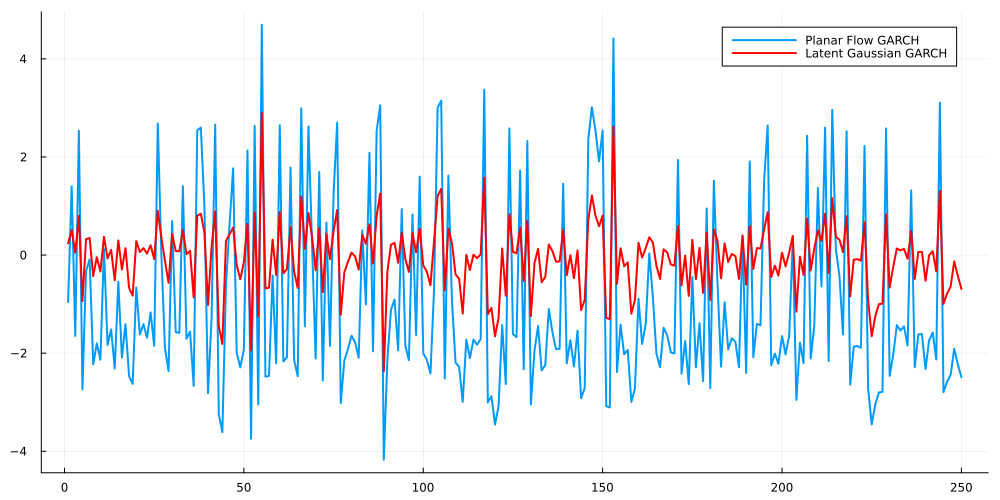

In [3]:
using Flux

struct PF_GARCH #(=Planar-Flow-GARCH)
    sigma0 #prior variance
    gamma
    alpha
    beta
    flow
end
Flux.@functor PF_GARCH #for differentiability later on


function simulate(m::PF_GARCH, T=250)
   
    gamma = softplus(m.gamma[1,1])
    alpha = σ(m.alpha[1,1])
    beta = σ(m.beta[1,1]) * (1-alpha) #constrain alpha and beta to sum to < 1
    
    sigeps = zeros(2,T+1)
    sigeps[1,1] = softplus(m.sigma0[1,1])
    
    for t in 2:T+1
        sigeps[1,t] = sqrt(gamma + alpha * sigeps[1,t-1]^2 + beta * sigeps[2,t-1]^2)
        sigeps[2,t] = randn()*sigeps[1,t]
    end
    
    return m.flow(sigeps[2:2,2:end])[:]
    
end

Random.seed!(123)
pf_garch = PF_GARCH(randn(1,1), randn(1,1), randn(1,1), randn(1,1), PlanarLayer([5.],[2.],[-2.]))

pf_garch_draw = simulate(pf_garch)
gauss_garch_draw = inverse(pf_garch.flow)(Matrix(transpose(pf_garch_draw[:,:])))[:]

plot(pf_garch_draw,label="Planar Flow GARCH",size=(1000,500),fmt=:png,lw=2)
plot!(gauss_garch_draw,label="Latent Gaussian GARCH",lw=2,color="red")

If we take a close look at the graph, we see that Planar Flow GARCH produces values that are either pretty large or pretty low. By scrolling back to the Planar Flow density plots, we see that this makes indeed sense. In fact, the Gaussian-large-non-linear flow generated a bi-modal distribution at around -3 and +3. This matches, approximately, the distribution of values that we see in the Planar Flow GARCH chart.

### Planar Flow GARCH on a real-world time series

To validate our model, we can fit it on a stock return time-series and analyze the result. Let us use the Apple adjusted close price as our dataset. I downloaded the data from Yahoo Finance - you can replicate it via [this link](https://de.finance.yahoo.com/quote/AAPL/history?period1=1498262400&period2=1656028800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true&ref=sarem-seitz.com).

As our target time-series, we use [log-returns](https://quantivity.wordpress.com/2011/02/21/why-log-returns/?ref=sarem-seitz.com). Also, we standardize them by subtracting their mean and dividing by their standard deviation. If you look at the range of values of the sample Planar Flow GARCH, this standardization makes sense as log-returns are typically on a much smaller scale. Afterwards, we can easily rescale our results back to actual log-returns.

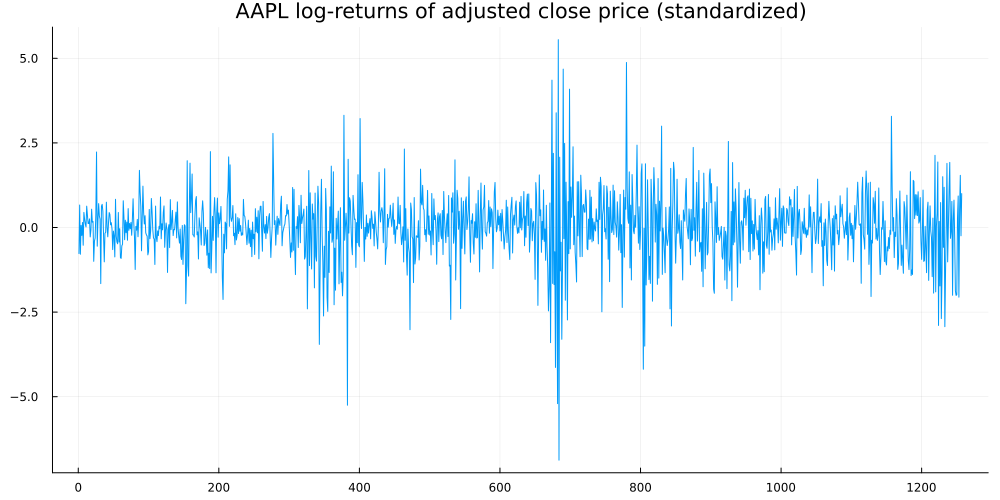

In [4]:
using CSV, DataFrames, Flux, Zygote, Distributions

adj_close = (CSV.File("../data/AAPL.csv") |> DataFrame)[!,"Adj Close"]

rets = diff(log.(adj_close))

ym = mean(rets)
ys = std(rets)
rets = (rets.-ym)./ys

plot(rets, legend=:none, title = "AAPL log-returns of adjusted close price (standardized)", size = (1000,500),fmt=:png)

Next, we define the model log-likelihood and use the ADAM optimizer for first-order optimization. By projecting the parameters via softplus and sigmoid, we can perform unconstrained optimization. Unfortunately, Julias AutoDiff packages all errored on the Hessian matrix. Thus, the current implementation does not seem to permit second-order optimization.

For our implementation, we can mostly rely on Distributions.jl and Bijectors.jl. The latter makes the implementation of nested (deep) Planar Flows quite convenient.

In [8]:
using Zygote

function Distributions.logpdf(m::PF_GARCH,y)
    
    T = size(y,2)
    
    inverse_flow = inverse(m.flow)
    ytilde = inverse_flow(y) #get the underlying Gaussian GARCH 
    
    sigeps = Zygote.Buffer(zeros(2,T+1)) #stores sigma_t (1st row) and epsilon_t (2nd row)
    sigeps[2,1] = 0. #set initial epsilon to zero
    sigeps[1,1] = softplus(m.sigma0[1,1])
    
    gamma = softplus(m.gamma[1,1])
    alpha = σ(m.alpha[1,1])
    beta = σ(m.beta[1,1]) * (1-alpha) #constrain alpha and beta to sum to < 1
    
    for t in 2:T+1
        sigeps[1,t] = sqrt(gamma[1,1] + alpha[1,1] * sigeps[1,t-1]^2 + beta[1,1] * sigeps[2,t-1]^2) #sigma_t
        sigeps[2,t] = ytilde[t-1]/sigeps[1,t] #epsilon_t
    end
    
    vars = copy(sigeps)

    dists = map(x->MvNormal(zeros(1),x),vars[1,2:end].^2)
    flows = Flux.unsqueeze(transformed.(dists,m.flow),1)
    
    lpdfs = Zygote.Buffer(zeros(T),T)

    for t in 1:T
        lpdfs[t] = logpdf(flows[t],[y[t]]) #Bijectors.Composed flow expects vector valued variables
    end

    return mean(copy(lpdfs))
end


retsm = Matrix(transpose(rets[:,:])) #Bijectors.jl flows treat 1xN matrices as N observations from a single-value vector valued r.v.

pf_garch = PF_GARCH(zeros(1,1), zeros(1,1), zeros(1,1), zeros(1,1), PlanarLayer([0.5],[1.],[0.1])∘PlanarLayer([0.5],[1.],[0.1])∘PlanarLayer([0.5],[1.],[0.1]))


params = Flux.params(pf_garch)
opt = ADAM(0.025)


for i in 1:1000 #first-order optimization takes quite some time
    grads = Zygote.gradient(()->-logpdf(pf_garch,retsm),params)
    Flux.Optimise.update!(opt,params,grads)
end;

### The Planar Flow GARCH model after optimization
In order to check the outcome, let us plot several perspective. First, we start with in-sample and out-of-sample (=forecast) point predictions and predictive intervals. For the former, we use the median as we can calculate it analytically by applying the Normalizing Flow to the Gaussian median. Similarly, we can derive the 5% and 95% quantiles of the transformed variable via the respective Gaussian quantiles.

Additionally, notice that we need to integrate out the unrealized noise terms for the forecast distributions, i.e.:
$$
p\left(\tilde{y}_t\right)=\int p\left(\tilde{y}_t \mid \epsilon_t, \epsilon_{t-1}\right) p\left(\epsilon_t\right) p\left(\epsilon_{t-1}\right) d \epsilon_t d \epsilon_{t-1}
$$
if $t-1$ lies inside the forecast interval

As this would be tedious, we will use our model to sample from the forecast distribution and integrate the noise out implicitly.

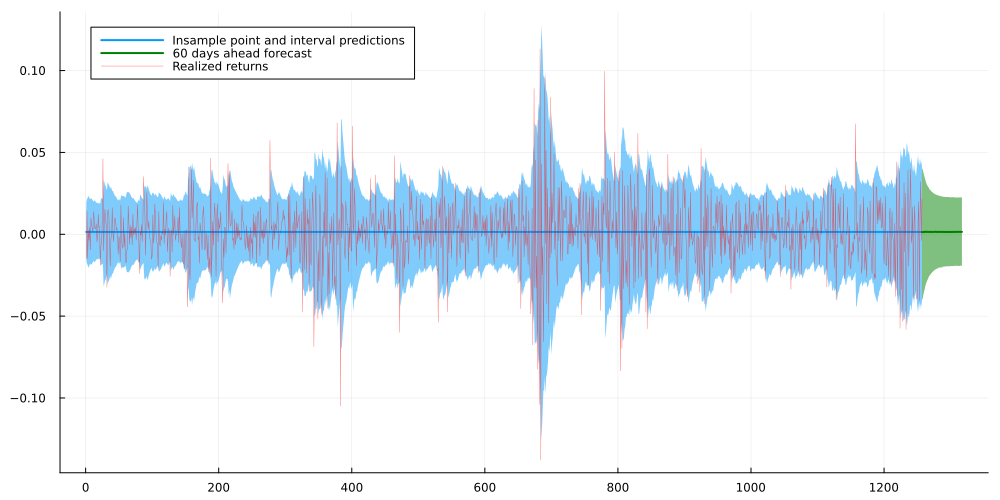

In [9]:
function get_insample_distributions(m::PF_GARCH, y)
    
    T = size(y,2)
    
    inverse_flow = inverse(m.flow)
    ytilde = inverse_flow(y)
    
    gamma = softplus(m.gamma[1,1])
    alpha = σ(m.alpha[1,1])
    beta = σ(m.beta[1,1]) * (1-alpha) #constrain alpha and beta to sum to < 1
    
    sigeps_insample = zeros(2,T+1) #stores sigma_t (1st row) and epsilon_t (2nd row)
    sigeps_insample[1,1] = softplus(m.sigma0[1,1])
    
    for t in 2:T+1
        sigeps_insample[1,t] = sqrt(gamma + alpha * sigeps_insample[1,t-1]^2 + beta * sigeps_insample[2,t-1]^2)
        sigeps_insample[2,t] = ytilde[t-1]/(sigeps_insample[1,t]+1e-6)
    end
    
    dists_insample = map(x->MvNormal(zeros(1),x),sigeps_insample[1,2:end].^2)
    flows_insample = Flux.unsqueeze(transformed.(dists_insample,m.flow),1)
    
    dists_insample = map(x->MvNormal(zeros(1),x),sigeps_insample[1,2:end].^2)
    flows_insample = Flux.unsqueeze(transformed.(dists_insample,m.flow),1)
    
    return flows_insample, sigeps_insample
end



function sample_forecast(m::PF_GARCH, sigeps_insample, forecast_periods=60)
    
    gamma = softplus(m.gamma[1,1])
    alpha = σ(m.alpha[1,1])
    beta = σ(m.beta[1,1]) * (1-alpha) #constrain alpha and beta to sum to < 1
    
    sigeps_forecast = zeros(2,forecast_periods+1) #stores sigma_t (1st row) and epsilon_t (2nd row)
    sigeps_forecast[1,1] = sigeps_insample[1,end]
    sigeps_forecast[2,1] = sigeps_insample[2,end]
    
    for t in 2:forecast_periods+1
        sigeps_forecast[1,t] = sqrt(gamma + alpha * sigeps_forecast[1,t-1]^2 + beta * sigeps_forecast[2,t-1]^2)
        sigeps_forecast[2,t] = randn()
    end
    
    dists_forecast = map(x->MvNormal(zeros(1),x),sigeps_forecast[1,:].^2)
    flows_forecast = Flux.unsqueeze(transformed.(dists_forecast,m.flow),1)
    
    return vcat(rand.(flows_forecast)[:]...)
    
end

#--------------------------

pf_garch_insample, sigeps_insample = get_insample_distributions(pf_garch,retsm)

pf_garch_5perc_quantile = [r.transform([quantile(Normal(0,sqrt(r.dist.Σ[1])),0.05)])[1] for r in pf_garch_insample][:] .* ys .+ ym
pf_garch_95perc_quantile = [r.transform([quantile(Normal(0,sqrt(r.dist.Σ[1])),0.95)])[1] for r in pf_garch_insample][:] .* ys .+ ym
pf_garch_median = [r.transform([quantile(Normal(0,sqrt(r.dist.Σ[1])),0.5)])[1] for r in pf_garch_insample][:].* ys .+ ym


forecast = hcat([sample_forecast(pf_garch, sigeps_insample) for _ in 1:75000]...) .* ys .+ ym

forecast_5perc_quantile = mapslices(x->quantile(x,0.05),forecast,dims=2)[:]
forecast_95perc_quantile = mapslices(x->quantile(x,0.95),forecast,dims=2)[:]
forecast_median = mapslices(x->quantile(x,0.5),forecast,dims=2)[:]


plot(pf_garch_median,
     ribbon = (pf_garch_median.-pf_garch_5perc_quantile,pf_garch_95perc_quantile.-pf_garch_median),
     lw=2,size=(1000,500), fmt=:png, label = "Insample point and interval predictions")
plot!(collect(length(rets):60+length(rets)),forecast_median,ribbon = (forecast_median.-forecast_5perc_quantile,forecast_95perc_quantile.-forecast_median),
      lw=2,color="green", label="60 days ahead forecast")
plot!(rets.* ys .+ ym, alpha=0.5,color="red",lw=0.5, label="Realized returns")

Both in- and out-of-sample predictive intervals and point predictions look reasonable. In case we preferred to use the mean instead of the median as the point estimate, we could, for example, use Monte Carlo samples to estimate the former.

In a real-world scenario, we might want to take a closer look at the forecast predictive interval. As a matter of fact, it appears a little too small and might actually under-estimate potential risk. Apart from that, however, the model seems to correctly depict the typical GARCH volatility clusters.

Finally, let us check the conditional distributions after the largest and smallest amplitudes. This gives us a visual impression of how far our model deviates from Gaussian conditional returns as in standard GARCH.

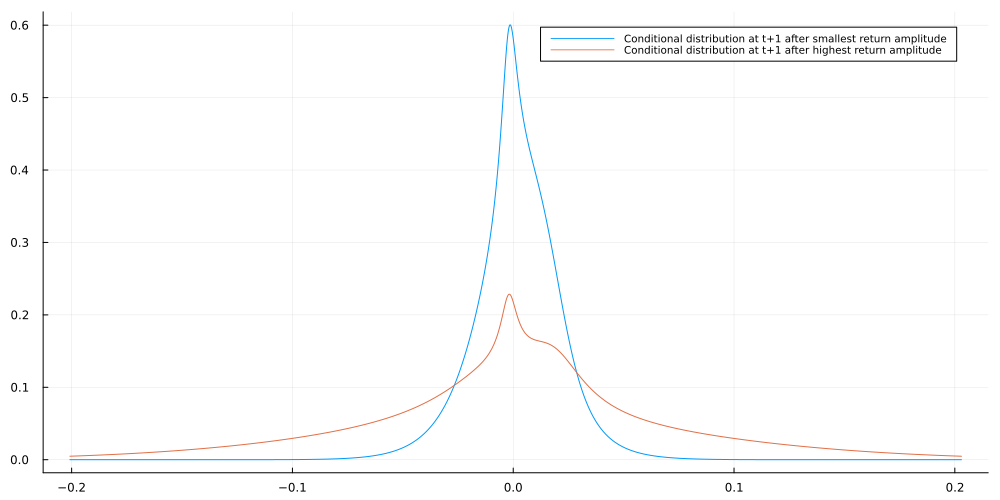

In [10]:
plot(collect(-10:0.01:10).* ys .+ ym,[pdf(pf_garch_insample[argmin(rets.^2)+1],[x]) for x in collect(-10:0.01:10)],
     size=(1000,500), label = "Conditional distribution at t+1 after smallest return amplitude", legendfontsize=7)

plot!(collect(-10:0.01:10).* ys .+ ym,[pdf(pf_garch_insample[argmax(rets.^2)+1],[x]) for x in collect(-10:0.01:10)],
     label = "Conditional distribution at t+1 after highest return amplitude", legendfontsize=7)

Indeed, our model is highly non-Gaussian. Also, as expected, the conditional return distribution clearly spreads out after large returns amplitudes - i.e. volatility increases after shocks.

## GARCH and Normalizing Flows - Conclusion
In this article, we took a timeless model from quantitative finance and combined it with a popular machine learning approach. The outcome is quite interesting insofar as it can infer conditional return distribution from data. This is in contrast to classic statistical models where the user typically fixes the distribution ex-ante. As long as the time-series is long enough, this might yield better predictive results. After all, Gaussian and related distributional assumptions often simplify the real world too far.

To improve the model further from here, we might want to consider more complex GARCH dynamics. The GARCH(1,1) was mainly for convenience and higher order GARCH models would likely be better suited.

Besides that, we could use a more sophisticated version of GARCH altogether. You might want to take a look at [Wikipedia](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity?ref=sarem-seitz.com) for a non-exhaustive list of advanced versions of GARCH. Finally, we could also replace the Planar Flows with more advanced alternatives. As an example, consider [Sylvester Flows](https://arxiv.org/pdf/1803.05649.pdf?ref=sarem-seitz.com) which generalize Planar Flows.

As always though, we should not fool ourselves by choosing the complex ML-ish approach just because that is trendy. Rather, all candidate models should be carefully evaluated against each other. Nevertheless, it would be interesting to check if this approach could be useful for an actual real-world trading strategy.

## References
**[1]** Bollerslev, Tim. Generalized autoregressive conditional heteroskedasticity. Journal of econometrics, 1986, 31. 3, p. 307-327.

**[2]** Rezende, Danilo; Mohamed, Shakir. Variational inference with normalizing flows. In: International conference on machine learning. PMLR, 2015. p. 1530-1538.

**[3]** Kobyzev, Ivan; Prince, Simon JD; Brubaker, Marcus A. Normalizing flows: An introduction and review of current methods. IEEE transactions on pattern analysis and machine intelligence, 2020, 43. 11, p. 3964-3979.